# Twitter Sentiment Analysis

In [2]:
!pip install gensim --upgrade
!pip install keras --upgrade
!pip install pandas --upgrade

  Using cached https://files.pythonhosted.org/packages/09/ed/b59a2edde05b7f5755ea68648487c150c7c742361e9c8733c6d4ca005020/gensim-3.8.1-cp37-cp37m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/83/94/7179c3832a6d45b266ddb2aac329e101367fbdb11f425f13771d27f225bb/jmespath-0.9.4-py2.py3-none-any.whl
  Created wheel for smart-open: filename=smart_open-1.9.0-cp37-none-any.whl size=73092 sha256=bbadc152fe1b4502342f33a9b30d29a32f40f4e1674fefd041e78e09eab9eace
  Stored in directory: C:\Users\KRISHNA PRASAD P\AppData\Local\pip\Cache\wheels\ab\10\93\5cff86f5b721d77edaecc29959b1c60d894be1f66d91407d28
Successfully built smart-open
  Using cached https://files.pythonhosted.org/packages/ad/fd/6bfe87920d7f4fd475acd28500a42482b6b84479832bdc0fe9e589a60ceb/Keras-2.3.1-py2.py3-none-any.whl
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5
  Found existing installation: pandas 0.25.1
    Uninstalling pandas-0.25.1:
     

ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'c:\\users\\krishna prasad p\\appdata\\roaming\\python\\python37\\site-packages\\~andas\\io\\msgpack\\_packer.cp37-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [1]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Using TensorFlow backend.


In [2]:
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

### Settings

In [27]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

### Read Dataset

### Dataset details
* **target**: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
* **ids**: The id of the tweet ( 2087)
* **date**: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
* **flag**: The query (lyx). If there is no query, then this value is NO_QUERY.
* **user**: the user that tweeted (robotickilldozr)
* **text**: the text of the tweet (Lyx is cool)

In [15]:
# dataset_filename = os.listdir("../input")[0]
dataset_path = './data.csv'
print("Open file:", dataset_path)
df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

Open file: ./data.csv


In [16]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [17]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


### Map target label to String
* **0** -> **NEGATIVE**
* **2** -> **NEUTRAL**
* **4** -> **POSITIVE**

In [18]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [19]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

Wall time: 1.09 s


In [1]:
df.head(5)

NameError: name 'df' is not defined

Text(0.5, 1.0, 'Dataset labels distribuition')

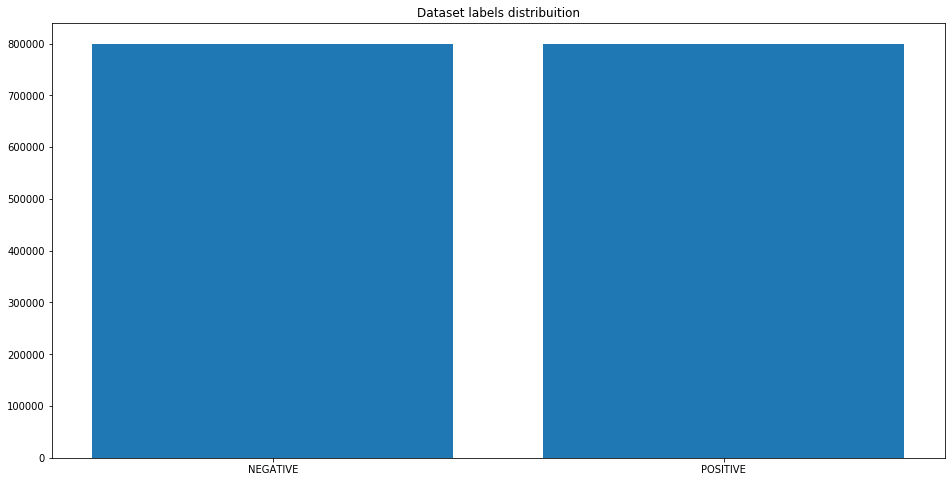

In [21]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

### Pre-Process dataset

In [22]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [23]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [24]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

Wall time: 1min 38s


### Split train and test

In [25]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


### Word2Vec 
https://towardsdatascience.com/a-beginners-guide-to-word-embedding-with-gensim-word2vec-model-5970fa56cc92

In [26]:
%%time
documents = [_text.split() for _text in df_train.text] 
documents[0:5]

Wall time: 4.77 s


[['ya',
  'quot',
  'like',
  'palm',
  'pre',
  'touchstone',
  'charger',
  'readynow',
  'yes',
  'sounds',
  'good',
  'beer',
  'ready',
  'prelaunch'],
 ['felt', 'earthquake', 'afternoon', 'seems', 'epicenter'],
 ['ruffles', 'shirts', 'like', 'likey'],
 ['pretty',
  'bad',
  'night',
  'crappy',
  'morning',
  'fml',
  'buttface',
  'didnt',
  'say',
  'could',
  'go',
  'work',
  'today'],
 ['yeah', 'clear', 'view']]

https://machinelearningmastery.com/gentle-introduction-bag-words-model/

https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html

https://pathmind.com/wiki/word2vec


In [28]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [29]:
w2v_model.build_vocab(documents)

2020-01-21 21:26:34,372 : INFO : collecting all words and their counts
2020-01-21 21:26:34,372 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-01-21 21:26:34,392 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2020-01-21 21:26:34,410 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2020-01-21 21:26:34,442 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2020-01-21 21:26:34,470 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2020-01-21 21:26:34,511 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2020-01-21 21:26:34,535 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2020-01-21 21:26:34,578 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 46458 word types
2020-01-21 21:26:34,641 : INFO : PROGRESS: at s

2020-01-21 21:26:36,912 : INFO : PROGRESS: at sentence #720000, processed 5193881 words, keeping 200325 word types
2020-01-21 21:26:36,946 : INFO : PROGRESS: at sentence #730000, processed 5265467 words, keeping 202133 word types
2020-01-21 21:26:36,975 : INFO : PROGRESS: at sentence #740000, processed 5337518 words, keeping 203818 word types
2020-01-21 21:26:37,011 : INFO : PROGRESS: at sentence #750000, processed 5409321 words, keeping 205535 word types
2020-01-21 21:26:37,044 : INFO : PROGRESS: at sentence #760000, processed 5481512 words, keeping 207282 word types
2020-01-21 21:26:37,095 : INFO : PROGRESS: at sentence #770000, processed 5554093 words, keeping 209076 word types
2020-01-21 21:26:37,128 : INFO : PROGRESS: at sentence #780000, processed 5625382 words, keeping 210805 word types
2020-01-21 21:26:37,164 : INFO : PROGRESS: at sentence #790000, processed 5698066 words, keeping 212618 word types
2020-01-21 21:26:37,224 : INFO : PROGRESS: at sentence #800000, processed 577088

In [22]:
# words = w2v_model.wv.vocab.keys()
# vocab_size = len(words)
# print("Vocab size", vocab_size)


In [30]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2020-01-21 21:26:50,062 : INFO : training model with 8 workers on 30369 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2020-01-21 21:26:51,112 : INFO : EPOCH 1 - PROGRESS: at 7.38% examples, 585300 words/s, in_qsize 14, out_qsize 1
2020-01-21 21:26:52,133 : INFO : EPOCH 1 - PROGRESS: at 15.30% examples, 611086 words/s, in_qsize 16, out_qsize 0
2020-01-21 21:26:53,139 : INFO : EPOCH 1 - PROGRESS: at 23.31% examples, 626466 words/s, in_qsize 15, out_qsize 0
2020-01-21 21:26:54,138 : INFO : EPOCH 1 - PROGRESS: at 31.10% examples, 630072 words/s, in_qsize 15, out_qsize 0
2020-01-21 21:26:55,146 : INFO : EPOCH 1 - PROGRESS: at 38.89% examples, 631415 words/s, in_qsize 14, out_qsize 1
2020-01-21 21:26:56,145 : INFO : EPOCH 1 - PROGRESS: at 46.89% examples, 635839 words/s, in_qsize 15, out_qsize 0
2020-01-21 21:26:57,148 : INFO : EPOCH 1 - PROGRESS: at 54.35% examples, 632744 words/s, in_qsize 14, out_qsize 1
2020-01-21 21:26:58,161 : INFO : EPOCH 1 - PROGRESS: 

2020-01-21 21:27:41,401 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-01-21 21:27:41,416 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01-21 21:27:41,421 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-21 21:27:41,423 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-01-21 21:27:41,437 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-21 21:27:41,440 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-21 21:27:41,448 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-21 21:27:41,452 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-21 21:27:41,452 : INFO : EPOCH - 4 : training on 9227204 raw words (8222143 effective words) took 13.0s, 633663 effective words/s
2020-01-21 21:27:42,481 : INFO : EPOCH 5 - PROGRESS: at 7.06% examples, 571259 words/s, in_qsize 14, out_qsize 1
2020-01-21 21:27:43,4

2020-01-21 21:28:27,546 : INFO : EPOCH 8 - PROGRESS: at 54.14% examples, 625833 words/s, in_qsize 15, out_qsize 0
2020-01-21 21:28:28,549 : INFO : EPOCH 8 - PROGRESS: at 61.93% examples, 627445 words/s, in_qsize 16, out_qsize 0
2020-01-21 21:28:29,566 : INFO : EPOCH 8 - PROGRESS: at 69.61% examples, 626907 words/s, in_qsize 14, out_qsize 2
2020-01-21 21:28:30,568 : INFO : EPOCH 8 - PROGRESS: at 77.42% examples, 627952 words/s, in_qsize 13, out_qsize 2
2020-01-21 21:28:31,574 : INFO : EPOCH 8 - PROGRESS: at 85.34% examples, 629757 words/s, in_qsize 16, out_qsize 0
2020-01-21 21:28:32,593 : INFO : EPOCH 8 - PROGRESS: at 93.05% examples, 628922 words/s, in_qsize 16, out_qsize 0
2020-01-21 21:28:33,372 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-01-21 21:28:33,378 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01-21 21:28:33,384 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-21 21:28:33,386 : INFO : worker thr

2020-01-21 21:29:13,076 : INFO : EPOCH 12 - PROGRESS: at 7.28% examples, 577375 words/s, in_qsize 15, out_qsize 0
2020-01-21 21:29:14,077 : INFO : EPOCH 12 - PROGRESS: at 15.41% examples, 621305 words/s, in_qsize 15, out_qsize 0
2020-01-21 21:29:15,096 : INFO : EPOCH 12 - PROGRESS: at 23.20% examples, 624040 words/s, in_qsize 16, out_qsize 1
2020-01-21 21:29:16,113 : INFO : EPOCH 12 - PROGRESS: at 30.89% examples, 623448 words/s, in_qsize 15, out_qsize 1
2020-01-21 21:29:17,134 : INFO : EPOCH 12 - PROGRESS: at 38.89% examples, 628026 words/s, in_qsize 16, out_qsize 1
2020-01-21 21:29:18,135 : INFO : EPOCH 12 - PROGRESS: at 46.67% examples, 630135 words/s, in_qsize 16, out_qsize 1
2020-01-21 21:29:19,158 : INFO : EPOCH 12 - PROGRESS: at 54.45% examples, 629883 words/s, in_qsize 16, out_qsize 0
2020-01-21 21:29:20,176 : INFO : EPOCH 12 - PROGRESS: at 62.57% examples, 633130 words/s, in_qsize 15, out_qsize 0
2020-01-21 21:29:21,175 : INFO : EPOCH 12 - PROGRESS: at 70.37% examples, 633924 

2020-01-21 21:30:03,967 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01-21 21:30:03,973 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-21 21:30:03,976 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-01-21 21:30:03,986 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-21 21:30:03,989 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-21 21:30:03,993 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-21 21:30:04,005 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-21 21:30:04,005 : INFO : EPOCH - 15 : training on 9227204 raw words (8222505 effective words) took 12.9s, 636941 effective words/s
2020-01-21 21:30:05,020 : INFO : EPOCH 16 - PROGRESS: at 7.17% examples, 587667 words/s, in_qsize 15, out_qsize 0
2020-01-21 21:30:06,038 : INFO : EPOCH 16 - PROGRESS: at 14.97% examples, 609099 words/s, in_qsize 14, out_qsi

2020-01-21 21:30:49,866 : INFO : EPOCH 19 - PROGRESS: at 52.84% examples, 610434 words/s, in_qsize 14, out_qsize 1
2020-01-21 21:30:50,885 : INFO : EPOCH 19 - PROGRESS: at 60.74% examples, 613679 words/s, in_qsize 16, out_qsize 0
2020-01-21 21:30:51,891 : INFO : EPOCH 19 - PROGRESS: at 68.42% examples, 615469 words/s, in_qsize 15, out_qsize 0
2020-01-21 21:30:52,903 : INFO : EPOCH 19 - PROGRESS: at 76.33% examples, 618089 words/s, in_qsize 15, out_qsize 0
2020-01-21 21:30:53,956 : INFO : EPOCH 19 - PROGRESS: at 84.16% examples, 617137 words/s, in_qsize 16, out_qsize 0
2020-01-21 21:30:54,976 : INFO : EPOCH 19 - PROGRESS: at 92.28% examples, 620336 words/s, in_qsize 15, out_qsize 0
2020-01-21 21:30:55,851 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-01-21 21:30:55,855 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01-21 21:30:55,860 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-21 21:30:55,861 : INFO : work

2020-01-21 21:31:35,941 : INFO : EPOCH 23 - PROGRESS: at 7.49% examples, 613502 words/s, in_qsize 14, out_qsize 1
2020-01-21 21:31:36,950 : INFO : EPOCH 23 - PROGRESS: at 15.41% examples, 628582 words/s, in_qsize 16, out_qsize 1
2020-01-21 21:31:37,954 : INFO : EPOCH 23 - PROGRESS: at 23.31% examples, 635056 words/s, in_qsize 15, out_qsize 2
2020-01-21 21:31:38,986 : INFO : EPOCH 23 - PROGRESS: at 31.21% examples, 633789 words/s, in_qsize 15, out_qsize 0
2020-01-21 21:31:40,015 : INFO : EPOCH 23 - PROGRESS: at 39.11% examples, 633446 words/s, in_qsize 14, out_qsize 1
2020-01-21 21:31:41,028 : INFO : EPOCH 23 - PROGRESS: at 47.00% examples, 634759 words/s, in_qsize 15, out_qsize 0
2020-01-21 21:31:42,034 : INFO : EPOCH 23 - PROGRESS: at 54.78% examples, 635080 words/s, in_qsize 16, out_qsize 1
2020-01-21 21:31:43,056 : INFO : EPOCH 23 - PROGRESS: at 62.79% examples, 636530 words/s, in_qsize 15, out_qsize 2
2020-01-21 21:31:44,056 : INFO : EPOCH 23 - PROGRESS: at 70.70% examples, 637933 

2020-01-21 21:32:26,814 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-01-21 21:32:26,833 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01-21 21:32:26,833 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-21 21:32:26,835 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-01-21 21:32:26,848 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-21 21:32:26,856 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-21 21:32:26,867 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-21 21:32:26,877 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-21 21:32:26,878 : INFO : EPOCH - 26 : training on 9227204 raw words (8222764 effective words) took 12.8s, 640364 effective words/s
2020-01-21 21:32:27,899 : INFO : EPOCH 27 - PROGRESS: at 7.17% examples, 583214 words/s, in_qsize 14, out_qsize 1
2020-01-21 21:32:28

2020-01-21 21:33:12,721 : INFO : EPOCH 30 - PROGRESS: at 53.81% examples, 627200 words/s, in_qsize 15, out_qsize 0
2020-01-21 21:33:13,743 : INFO : EPOCH 30 - PROGRESS: at 62.03% examples, 631583 words/s, in_qsize 15, out_qsize 0
2020-01-21 21:33:14,774 : INFO : EPOCH 30 - PROGRESS: at 69.61% examples, 628648 words/s, in_qsize 15, out_qsize 0
2020-01-21 21:33:15,813 : INFO : EPOCH 30 - PROGRESS: at 77.63% examples, 629209 words/s, in_qsize 16, out_qsize 0
2020-01-21 21:33:16,819 : INFO : EPOCH 30 - PROGRESS: at 85.45% examples, 629928 words/s, in_qsize 12, out_qsize 3
2020-01-21 21:33:17,832 : INFO : EPOCH 30 - PROGRESS: at 93.37% examples, 630998 words/s, in_qsize 15, out_qsize 0
2020-01-21 21:33:18,564 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-01-21 21:33:18,571 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01-21 21:33:18,573 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-21 21:33:18,574 : INFO : work

Wall time: 6min 54s


(263127334, 295270528)

In [39]:
w2v_model.most_similar("love")

C:\Users\KRISHNA PRASAD P\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('luv', 0.5845032930374146),
 ('loves', 0.5546305179595947),
 ('loved', 0.5534921884536743),
 ('amazing', 0.5110648274421692),
 ('adore', 0.5036742687225342),
 ('looove', 0.485459566116333),
 ('loveee', 0.4781234562397003),
 ('awesome', 0.45939570665359497),
 ('loooove', 0.4559696912765503),
 ('lovee', 0.4417044520378113)]

In [40]:
w2v_model.similarity('move','go')

C:\Users\KRISHNA PRASAD P\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.41282398

### Tokenize Text
https://keras.io/preprocessing/text/


https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

In [63]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
Wall time: 17.2 s


In [86]:
df_train.text[0]

'awww bummer shoulda got david carr third day'

https://machinelearningmastery.com/prepare-text-data-deep-learning-keras/

In [87]:
tokenizer.texts_to_sequences(df_train.text[0])

[[],
 [181],
 [181],
 [181],
 [],
 [210],
 [15],
 [],
 [],
 [475],
 [219],
 [],
 [],
 [1129],
 [],
 [15],
 [499],
 [],
 [],
 [],
 [640],
 [],
 [],
 [],
 [],
 [],
 [714],
 [],
 [],
 [],
 [307],
 [],
 [219],
 [219],
 [],
 [],
 [1129],
 [],
 [219],
 [],
 [],
 [],
 [],
 []]

In [88]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

Wall time: 26.8 s


### Label Encoder 

In [65]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [66]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000,)
y_test (320000,)
y_train (1280000, 1)
y_test (320000, 1)


In [67]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [68]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]], dtype=int64)

### Embedding layer

In [90]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [91]:
embedding_matrix[10]

array([-2.13993654e-01, -1.10969496e+00, -1.70774683e-01,  2.10472131e+00,
        1.88466147e-01,  3.01042587e-01,  3.52580011e-01, -8.12475801e-01,
        5.20028286e-02, -6.02019846e-01,  1.05696821e+00, -9.12261084e-02,
        4.27098364e-01, -1.25994074e+00,  1.23717093e+00,  6.97268307e-01,
       -4.21278805e-01,  5.15994549e-01, -7.47559905e-01, -3.76945406e-01,
       -9.95786130e-01, -4.89366651e-01, -4.79547739e-01, -2.93195490e-02,
        8.48072231e-01, -1.52693784e+00,  3.50778371e-01, -1.93571523e-01,
       -1.26101291e-02, -3.70299190e-01, -1.72299862e-01, -6.22707009e-01,
        7.20909461e-02, -5.93955576e-01, -1.32653856e+00, -2.52410740e-01,
        5.97637355e-01,  4.53915866e-03,  1.02148438e+00,  7.06400812e-01,
        2.44697362e-01, -1.31150949e+00, -7.18063116e-02,  2.41271198e-01,
        1.05375230e+00,  3.15156490e-01, -5.28656006e-01,  1.55352503e-02,
       -7.87463665e-01,  1.47574091e+00, -1.14149928e+00,  1.28678524e+00,
        1.72944844e+00, -

In [92]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

### Build Model

https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21

In [93]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          87125700  
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


### Compile model

In [94]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


2020-01-21 22:21:41,685 : WARNING : From C:\Users\KRISHNA PRASAD P\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Callbacks

In [95]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [96]:
model.load_weights('nlp.h5')

### Train

In [ ]:
# %%time
# history = model.fit(x_train, y_train,
#                     batch_size=BATCH_SIZE,
#                     epochs=EPOCHS,
#                     validation_split=0.1,
#                     verbose=1,
#                     callbacks=callbacks)
# model.save('nlp.h5')

Train on 1152000 samples, validate on 128000 samples
Epoch 1/8
  15360/1152000 [..............................] - ETA: 2:12:58 - loss: 0.6438 - acc: 0.6188

### Evaluate

In [97]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

2020-01-21 22:22:46,925 : WARNING : From C:\Users\KRISHNA PRASAD P\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



320000/320000 [==============================] - 435s 1ms/step

ACCURACY: 0.7911999821662903
LOSS: 0.44547695817947386
Wall time: 7min 14s


In [33]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
# loss = history.history['loss']
# val_loss = history.history['val_loss']
 
# epochs = range(len(acc))
 
# plt.plot(epochs, acc, 'b', label='Training acc')
# plt.plot(epochs, val_acc, 'r', label='Validation acc')
# plt.title('Training and validation accuracy')
# plt.legend()
 
# plt.figure()
 
# plt.plot(epochs, loss, 'b', label='Training loss')
# plt.plot(epochs, val_loss, 'r', label='Validation loss')
# plt.title('Training and validation loss')
# plt.legend()
 
# plt.show()

### Predict

In [98]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [99]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [100]:
predict("I love the music")

{'label': 'POSITIVE',
 'score': 0.9719203114509583,
 'elapsed_time': 0.11070466041564941}

In [101]:
predict("I hate the rain")

{'label': 'NEGATIVE',
 'score': 0.006692883092910051,
 'elapsed_time': 0.01894998550415039}

In [102]:
predict("i don't know what i'm doing")

{'label': 'NEGATIVE',
 'score': 0.28236323595046997,
 'elapsed_time': 0.02094125747680664}

### Confusion Matrix

In [ ]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

 16000/320000 [>.............................] - ETA: 12:53

In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

In [ ]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

### Classification Report

In [ ]:
print(classification_report(y_test_1d, y_pred_1d))

### Accuracy Score

In [ ]:
accuracy_score(y_test_1d, y_pred_1d)

### Save model

In [ ]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)